## Synthetic Heterogeneous Data Regression - UMAL vs. Technique.Exp.I 'On fly variance estimation'

In this notebook, it is generated a synthetic heterogeneuous dataset with **the goal to evaluate heterogeneous aleatoric uncertainty**. 

The proposed solutions to model this type of uncertainty are: 

* *Solution 1 - 'Technique.I Prediction variance estimation on the fly'* In previous work, we have seen that one of the main disadvantages of the Technique Exp.I is **the usage of restrictive priors**. The usage of MSE in the loss function **assumes a normal distribution** on the [parameter estimation](#https://www.jessicayung.com/mse-as-maximum-likelihood/) which produces a simmetric variance distribution with predictions centered on the mean E[Y|X = x] [1]


* *Solution 2 - UMAL (Uncountable Mixture Asymetric Laplacian)* This technique avoids the usage of restrictive priors which provides **more flexibility under scenarios with high uncertainty**. It approximates a heterogeneous distribution P(Y|X=x) as a compound of N **Asymmetric laplace distirbutions (ALDs) or mixture of components**. [2][3]

**References**

[1] https://github.com/beeva/TEC_LAB-bayesian_probabilistic - *Libro de Aprendizajes*

[2] https://github.com/BBVA/UMAL

[3] [***Axel Brando, Jose A. Rodriguez-Serrano, Jordi Vitria, Alberto Rubio. "Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians." Advances in Neural Information Processing Systems. 2019.***](LINK)

#### Main hypothesis


> **H1: Can we use techniques with restrictive priors to model aleatoric uncertainty with zero-knowledge about this uncertainty? <ins>How does this restrictive prior affect model performance?</ins>**



#### Notebook Index

- [Generate heterogeneuos synthetic data](#synth_data)
- [Solution 1 - 'Technique.I Prediction variance estimation on the fly'](#sol1)
- [Solution 2 - UMAL (Uncountable Mixture Asymetric Laplacian)](#sol2)
- [Evaluation results - Negative Log Likelihood comparison](#nll)
- [Conclusions](#conclusions)

In [2]:
import sys 
sys.path.insert(0,'..')

import numpy as np
np.random.seed(41)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import statistics as stat

%matplotlib inline

# custom functions
from utilities import synth_data_generation

## Generate heterogeneous synthetic data 

<a id='synth_data'>Generate heterogeneuos synthetic data</a>

Here, it is generated a heterogeneous regresion synthetic dataset to evaluate aleatoric uncertainty under the violation of common assumptions.
For this purpose, the distribution of Y along the X axis will vary by zones using the following generator processes:
* Asymmetric
* Symmetric
* Uniform
* Multimodal

In [3]:
x_test_synthetic, y_test_synthetic, x_valid_synthetic, y_valid_synthetic,  \
x_train_synthetic, y_train_synthetic, zones, lst = synth_data_generation.umal_regre_heterogeneous()

x = x_train_synthetic
y = y_train_synthetic

In [4]:
x.shape, y.shape, zones

((1710, 1),
 (1710, 1),
 [[800, 'Asymmetric'],
  [1800, 'Symmetric'],
  [2300, 'Uniform'],
  [3800, 'Multimodal']])

**Plot the generated synthetic dataset**

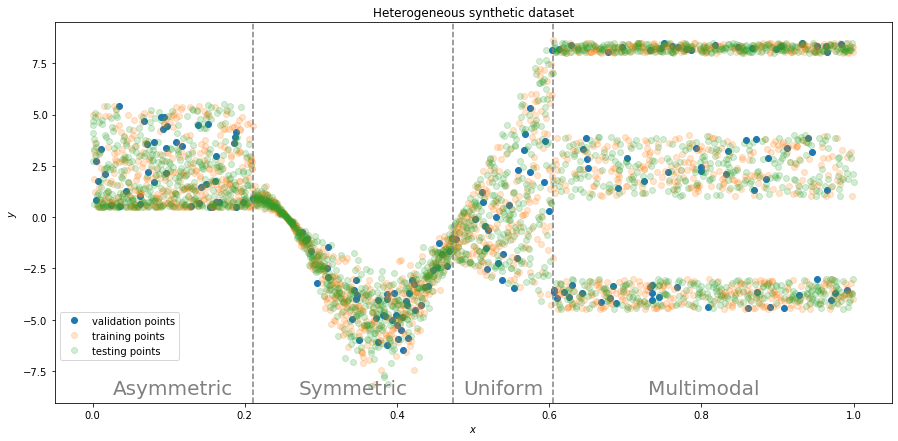

((1710, 1), (190, 1), (1900, 1))

In [59]:
plt.figure(figsize=(15,7))
plt.title('Heterogeneous synthetic dataset')

plt.plot(x_valid_synthetic,y_valid_synthetic,'o',label='validation points')
plt.plot(x_train_synthetic,y_train_synthetic,'o',label='training points',alpha=0.2)
plt.plot(x_test_synthetic,y_test_synthetic,'o',label='testing points',alpha=0.2)
for i in range(len(zones)):
    if i!= len(zones)-1:
        plt.axvline(x=zones[i][0]/len(lst),linestyle='--', c='grey')
    if i==0:
        plt.text(x=(zones[i][0])/(2*len(lst)),y=y_train_synthetic.min()-0.5,
                 s=zones[i][1], horizontalalignment='center', fontsize=20, color='grey')
    else:
        plt.text(x=(zones[i-1][0]+zones[i][0])/(2*len(lst)),y=y_train_synthetic.min()-0.5,
                 s=zones[i][1], horizontalalignment='center', fontsize=20, color='grey')

plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend(loc="lower left", bbox_to_anchor=(0.,0.1))
plt.show()

x_train_synthetic.shape, x_valid_synthetic.shape, x_test_synthetic.shape

#### Plot the distribution for each zone

Here, we will visualize the underlying distribution P(Y|X) of the generated synthetic dataset for each zone

In [85]:
size= 1000
points = np.random.beta(0.5, 1, 8 * size // 10) * 5 + 0.5
np.random.shuffle(points)

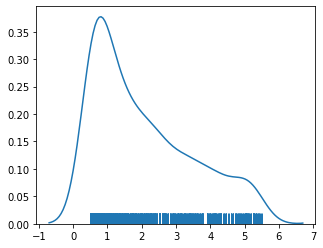

In [92]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.distplot(points.tolist(), hist=False, rug=True);

Aymmetric distribution with negative skew and leptokurtic 

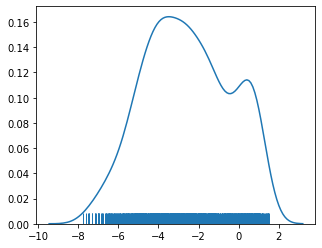

In [93]:
points = 3 * np.cos(np.linspace(0, 5, num=size)) - 2
points = points + np.random.normal(scale=np.abs(points) / 4, size=size)
import seaborn as sns
plt.figure(figsize=(5,4))
sns.distplot(points.tolist(), hist=False, rug=True);

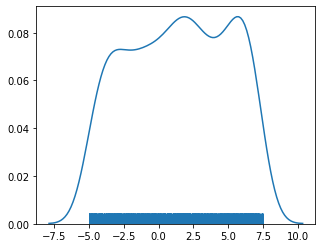

In [104]:
pts = [np.random.uniform(low=i, high=j)
        for i, j in zip(np.linspace(-2, -4.5, num=size // 2),
                        np.linspace(-0.5, 9., num=size // 2))]
plt.figure(figsize=(5,4))
sns.distplot(np.random.uniform(-5.0, 7.5, 1000), hist=False, rug=True);

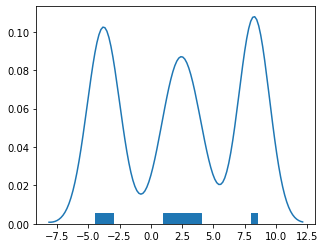

In [95]:
points = np.r_[8 + np.random.uniform(size=size // 2) * 0.5,
               1 + np.random.uniform(size=size // 2) * 3.,
               -4.5 + np.random.uniform(size=-(-size // 2)) * 1.5]
plt.figure(figsize=(5,4))
np.random.shuffle(points)
sns.distplot(points, hist=False, rug=True);

Multimodal distribution

The goal of this technique is to capture more complex features such as asymmetry or multimodality present in the different 'real' distribution P(Y|X) plotted above

## *Solution 1 - 'Technique.I Prediction variance estimation on the fly'*

<a id='sol1'>Solution 1 - 'Technique.I Prediction variance estimation on the fly'</a>

This solution requires a compound variable Y with two parameters (mu, sigma). We will create a custom loss function to estimate both parameters simultaneously 

In [6]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F

**Prepare data for training**

In [7]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(y.size)
y = np.stack([y[:,0], sigma], axis=1)

In [8]:
x = x.reshape(x[:,0].size, 1)

In [9]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

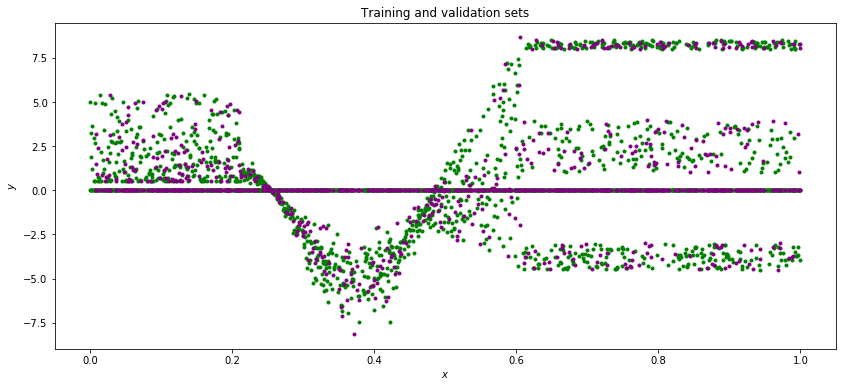

In [10]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

We initilialize sigma to 0.0 included in the compound tensor. We have 10000 data points in the dataset. We use 500 for validation

In [11]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [12]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([1210, 1]), torch.Size([1210, 2]))

In [13]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model_1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cuda()

In [14]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

#### Custom loss function

In [15]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

#### Training loop

In [16]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 4.2e+02
epoch:  500 loss: 1.41e+02
epoch: 1000 loss: 1.24e+02
epoch: 1500 loss: 1.18e+02
epoch: 2000 loss: 1.13e+02
epoch: 2500 loss: 1.09e+02
epoch: 3000 loss: 1.06e+02
epoch: 3500 loss: 1.02e+02
epoch: 4000 loss: 97.2
epoch: 4500 loss: 92.4
epoch: 5000 loss: 87.9
epoch: 5500 loss: 84.2
epoch: 6000 loss: 81.1
epoch: 6500 loss: 78.9
epoch: 7000 loss: 77.8
epoch: 7500 loss: 77.6
epoch: 8000 loss: 77.9
epoch: 8500 loss: 78.4
epoch: 9000 loss: 78.3
epoch: 9500 loss: 77.6


#### Get predictions for validation set

In [17]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

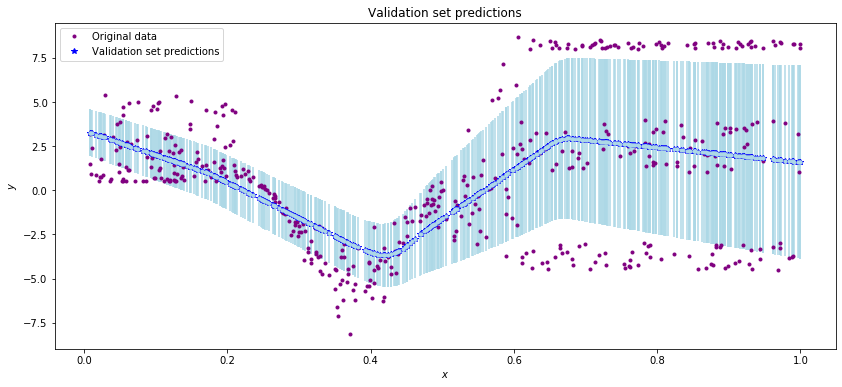

In [18]:
# Plot predictions and their errors
import numpy as np 

fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(x_val, y_val[:,0], '.', color='purple')
ax1.errorbar(x_val, y_pred_1, yerr=np.sqrt(sigma_pred_1) , color='lightblue', fmt='.'); 
ax1.plot(x_val, y_pred_1, '*', color='blue'); 

# One standard-deviation envelope
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data','Validation set predictions'], loc='upper left', );

* As we can see in this plot, we are able to capture the heterocedasticity in the dataset. There is a loss of performance in X=0.2 where it is not decreased the variance as expected.
* The variance estimation in each zone is centered on the mean E[Y|X=x] with a gaussian distribution 

## *Solution 2 - UMAL (Uncountable Mixture Asymetric Laplacian)*

<a id='sol1'>Solution 2 - UMAL (Uncountable Mixture Asymetric Laplacian)</a>

This is the proposed alternative solution without the usage of restrictive priors as it has been described in the introduction.

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

import tensorflow as tf
config = tf.ConfigProto()
## config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

from keras import backend as K

K.set_session(sess)
general_type = 'float64' #or 'float32'
K.set_floatx(general_type)

import keras
from keras.layers.core import Dense
from keras.layers import Activation

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np

from utilities import umal

C:\Users\yolan\Anaconda3\envs\tf-1.14\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


 We implement a simple hidden architecture similar to the one used in the Solution 1. This archictecture used 3 layers instead to be able to capture heterogeneous distributions

In [7]:
#Definition of the hidden layers. These layers could be any desired layers 
# as long as they return the penultimate internal representation to predict
# the forecasted parameters of the ALD conditioned to tau.

def hidden_architecture(i,name=""):
    model = Dense(units=120, activation="linear", name='FC0'+name)(i)
    model = Activation('relu')(model)
    
    model = Dense(units=60, activation="linear", name='FC1'+name)(model)
    model = Activation('relu')(model)
        
    model = Dense(units=10, activation="linear", name='FC2'+name)(model)
    model = Activation('relu')(model)
    
    return model







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 01698: early stopping


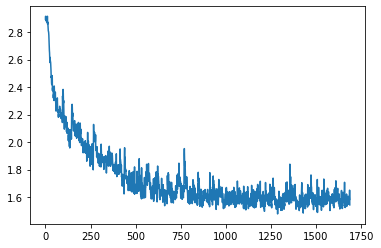

In [8]:
#Training process with verbose = 0. If you want to monitor the optimization process
# then change this parameter to 1.

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                   patience=400, verbose=1, mode='auto') 
                                   #restore_best_weights=True is needed in old Keras versions

syn_model = umal.build_UMAL(input_size=1,learning_rate=1e-2, architecture=hidden_architecture,
                        b_act=lambda x: umal.elu_modif(x,shift=1e-3))

K.set_value(syn_model.n_taus,100)
bs = 1000

losshistory = syn_model.fit(x_train_synthetic,y_train_synthetic, batch_size=bs,
                            epochs = 100000, initial_epoch=0, verbose=0,
                            validation_data=[x_valid_synthetic,y_valid_synthetic],
                            callbacks=[es])

plt.plot(losshistory.history['val_loss'][10:])

### Results section

We compute P(Y|X) for the whole synthetic dataset and visualize the predicted density function using UMAL

In [34]:
test_x_synthetic = np.expand_dims(np.linspace(x_train_synthetic.min(), x_train_synthetic.max(), 2000), 1)

syn_model_pred = umal.build_UMAL(**{**syn_model._hp,'training':False})
syn_model_pred.set_weights(syn_model.get_weights())
sel_taus = np.arange(0.+5e-2,1.-5e-2,0.01)

# Predict for each input point the parameters of the selected conditioned ALDs 
#  identified by sel_taus
pred_tmp = sess.run(syn_model_pred.output, 
                    feed_dict={syn_model_pred.input: test_x_synthetic,
                               syn_model_pred.taus:sel_taus}
                   ).reshape(-1,len(sel_taus),syn_model_pred.output.shape[-1]).transpose((1,0,2))

In [35]:
#Evaluate each ALD for a discretization of 1000 points over a certain desviation interval
dist, min_, max_, points = umal.calculate_distribution(pred_tmp, 1000, desv_from_minmax=10)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.61it/s]


In [36]:
#Calculate the UMAL distribution considering the mixture model
norm_dist = umal.np_log_sum_exp(dist,axis=-1).squeeze()-np.log(dist.shape[-1])

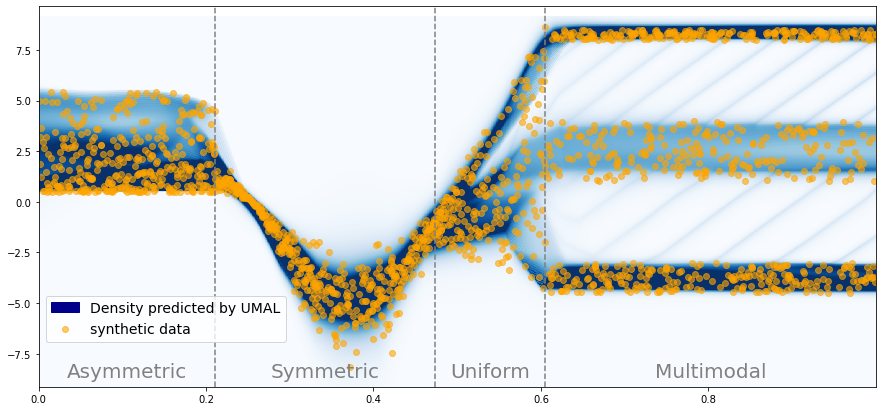

In [41]:
fig = plt.figure(figsize=(15., 7.))
        
plt.imshow(np.clip(np.flip(np.exp(norm_dist).T,axis=0),0.,0.2), 
           cmap=plt.cm.Blues, interpolation='none',
           extent=[x_train_synthetic.min(),x_train_synthetic.max(),min_,max_], aspect="auto")

sd = plt.scatter(x_train_synthetic, y_train_synthetic,c='orange', label='synthetic data',alpha=0.6)
        
patch = mpatches.Patch(color='darkblue', label='Density predicted by UMAL')       
for i in range(len(zones)):
    if i!= len(zones)-1:
        plt.axvline(x=zones[i][0]/len(lst),linestyle='--', c='grey')
    if i==0:
        plt.text(x=(zones[i][0])/(2*len(lst)),y=y_train_synthetic.min()-0.5,
                 s=zones[i][1], horizontalalignment='center', fontsize=20, color='grey')
    else:
        plt.text(x=(zones[i-1][0]+zones[i][0])/(2*len(lst)),y=y_train_synthetic.min()-0.5,
                 s=zones[i][1], horizontalalignment='center', fontsize=20, color='grey')

lgnd = plt.legend(handles=[patch, sd],loc="lower left", bbox_to_anchor=(0.,0.1), fontsize=14)

plt.ylim(y_train_synthetic.min()-1,y_train_synthetic.max()+1)
plt.show()

Here, we can see that we are able to succesfully estimate heterocedasticity as opposite of Solution.1
In addition, the predictions are not centered on the mean. This solution captures complex distirbutions of P(Y|X)

## *Evaluation results - Negative Log Likelihood comparison*

<a id='nll'>Evaluation results - Negative Log Likelihood comparison</a>

Here, we estimate with both methods the likelihood of P(Y|X=xi) where xi belongs to one of the 4 different zones (Multimodal, Uniform, Symmetric, Asymmetric)

In [26]:
xi_multimodal = np.array(np.linspace(0.6, 0.9, 100)).reshape(-1,1) 
xi_uniform = np.array(np.linspace(0.5, 0.6, 100)).reshape(-1,1) 
xi_symmetric = np.array(np.linspace(0.3, 0.5, 100)).reshape(-1,1) 
xi_asymmetric = np.array(np.linspace(0.1, 0.2, 100)).reshape(-1,1) 

xi_zones = {'Multimodal':xi_multimodal, 'Uniform':xi_uniform, 'Symmetric': xi_symmetric, 'Asymmetric':xi_asymmetric}

### *Solution 1 - 'Technique.I Prediction variance estimation on the fly'*

Visualization of the log-likelihood estimation P(Y|X) with the Solution 1

- NLL Multimodal : 7.397000


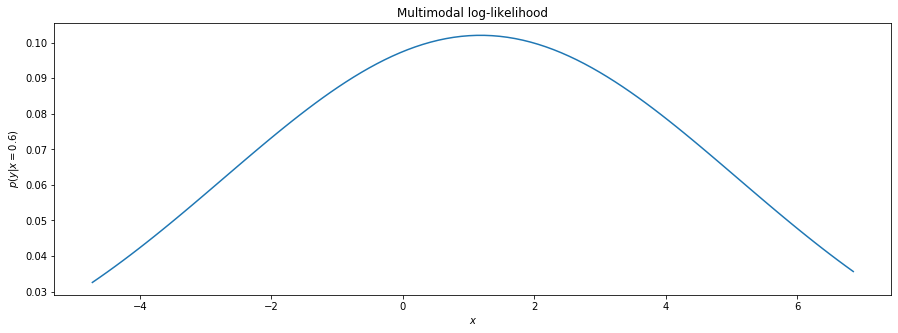

- NLL Uniform : 8.970786


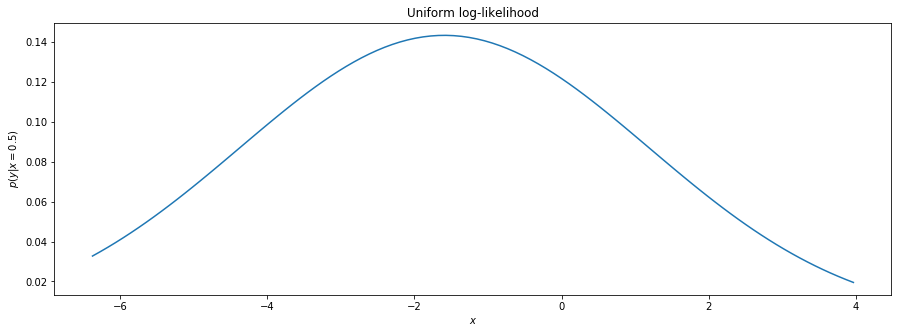

- NLL Symmetric : 11.348884


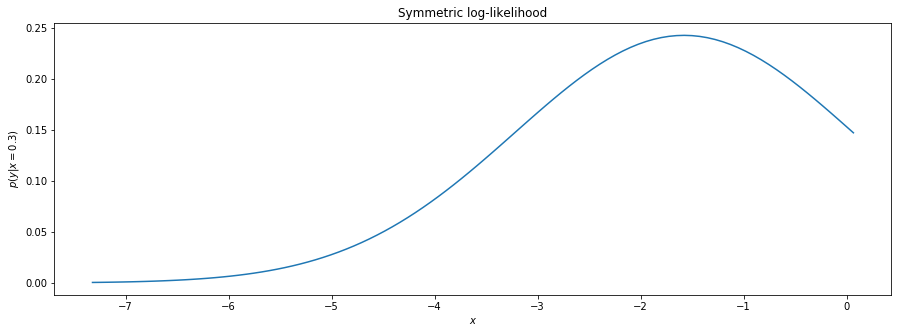

- NLL Asymmetric : 13.017526


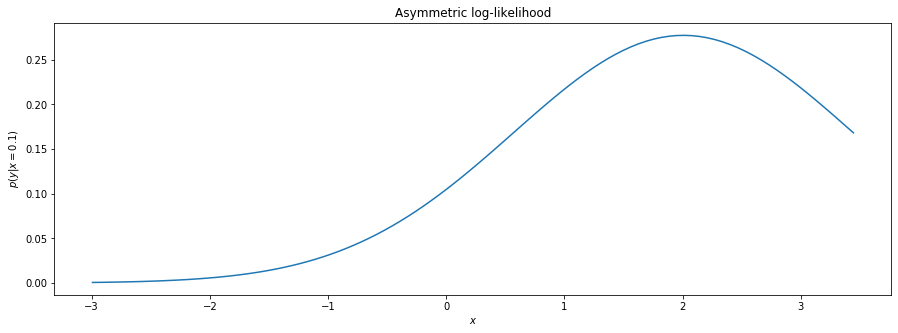

In [57]:
import scipy.stats as stats

for zone_name, xi in xi_zones.items():
    x_val_t = Variable(torch.from_numpy(np.array(xi)).type(dtype)) 
    pred_1 = model_1(x_val_t)
    # prediction of the response variables
    y_pred_1 = pred_1[:,0].cpu().data
    sigma_pred_1 = pred_1[:,1].cpu().data
    
    plt.figure(figsize=(15., 5.))
    plt.xlabel(r'$x$')
    plt.ylabel(r"$p(y|x=" + str(xi[0][0])+ ")$")
    plt.title(zone_name + ' log-likelihood');
    mu =  y_pred_1[0]
    sigma = sigma_pred_1[0]
    
    x = np.linspace(y_pred_1.min()-np.sqrt(sigma)-2, y_pred_1.max()+np.sqrt(sigma), 100)
    pdf = stats.norm.pdf(x, mu, np.sqrt(sigma))
    print('- NLL ' + zone_name + ' : ' + '{:f}'.format(np.sum(pdf)))
    plt.plot(x, pdf)
    #plt.xlim(-60,60)
    plt.show()

As we can see the estimated distribution is far away from the real one used for generating the synthetic dataset (see the synthetic dataset generation section)

### *Solution 2 - UMAL*

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.15it/s]


- NLL Multimodal : -39296.359027


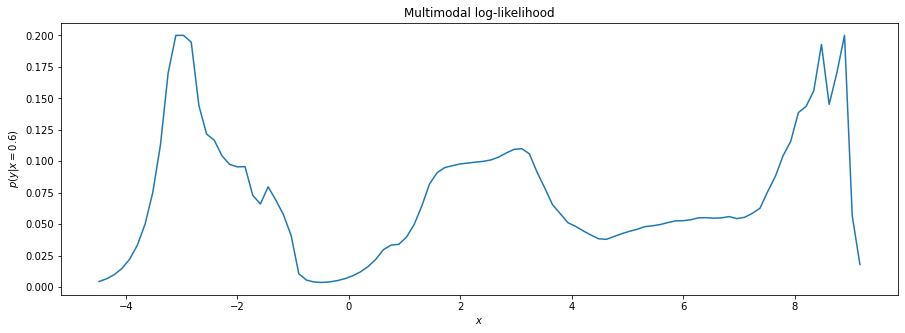

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.94it/s]


- NLL Uniform : -43287.121265


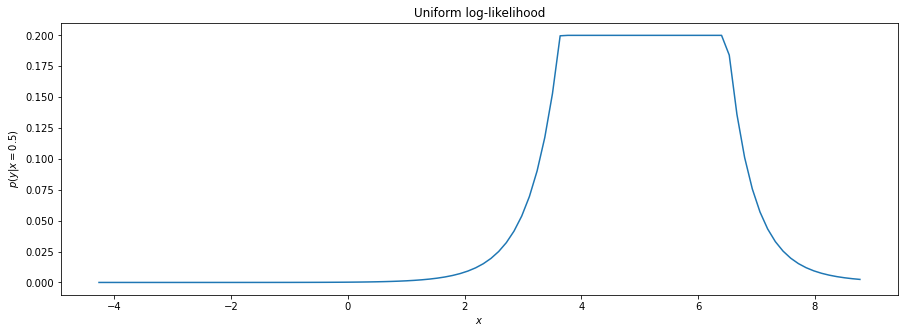

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.67it/s]


- NLL Symmetric : -51829.083785


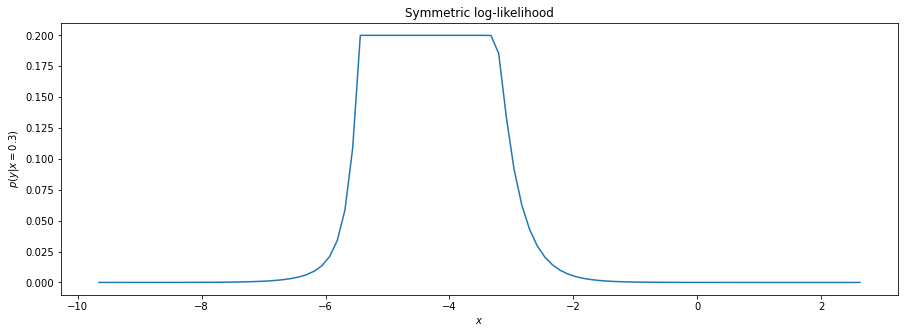

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.54it/s]


- NLL Asymmetric : -32644.537580


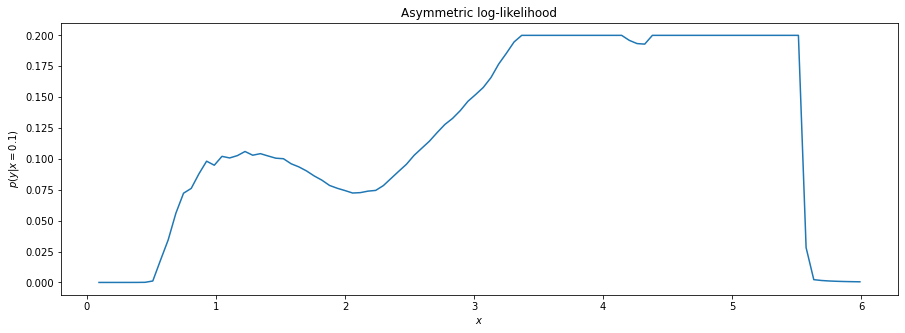

In [64]:
for zone_name, xi in xi_zones.items():
    pred_tmp_xi = sess.run(syn_model_pred.output, 
                        feed_dict={syn_model_pred.input: xi,
                                   syn_model_pred.taus:sel_taus}
                       ).reshape(-1,len(sel_taus),syn_model_pred.output.shape[-1]).transpose((1,0,2))
    #Evaluate each ALD for a discretization of 1000 points over a certain desviation interval
    dist, min_, max_, points = umal.calculate_distribution(pred_tmp_xi, xi.shape[0], desv_from_minmax=10)
    #Calculate the UMAL distribution considering the mixture model
    norm_dist = umal.np_log_sum_exp(dist,axis=-1).squeeze()-np.log(dist.shape[-1])
    print('- NLL ' + zone_name + ' : ' + '{:f}'.format(np.sum(norm_dist)))
    
    # plot the distribution for the first pto in the zone
    plt.figure(figsize=(15., 5.))
        
    y_values = np.linspace(min_, max_, norm_dist[0].shape[0])
    plt.plot(y_values, np.clip(np.flip(np.exp(norm_dist[0]).T,axis=0),0.,0.2))
    plt.xlabel(r'$x$')
    plt.ylabel(r"$p(y|x=" + str(xi[0][0])+ ")$")
    plt.title(zone_name + ' log-likelihood');
    plt.show()

The distributions obtained with the solution 2 are closer to the real distributions used for generating the synthetic dataset

## *Conclusions*

<a id='conclusions'>Conclusions</a>

**We have validate the hypothesis that UMAL (Solution 2) is able to model aleatoric uncertainty better than 'On fly variance estimation' (Solution 1)**. Particularly:

- **Heterocedasticity**: If we observe the variance estimation along the x-axis, we can see that both techniques are capable of modeling the variance of Y conditional to X. Nevertheless, we obtain better results in terms of global variance comparison with Solution 2. 



- **Heterogeneous distributions**: We have plotted the log-likelihood of Y according to a specific data point taken from each zone. Here, we can clearly observe that UMAL is better for modelling these distributions. The solution 2 is not able to approximate the real underlying distribution due to the restrictive assumption that Y has been generated according to gaussian distribution  

The Solution 2 presents **better performance in terms of prediction comparison** and it **gives more information about the underlying generated process of the dataset** in scenarios of high uncertainty 

### Future Work

The Solution 2. UMAL is able to capture heterogeneous distributions however it adds an extra complexity in the implementation. Additionally, the theory behind the solution is difficult to assimilate, there are complex numerical simplifications used in the loss (obtained using MLE) function to optimize the computation. 

--> *Proposed future steps*: There is also another technique able to capture these types of distributions: Mixture Density Networks (MDN). In the results presented in UMAL (paper referenced in the introduction) it is written that MDN are prone to overfitting with an output size that depends on the number of parameters. As a future work, we can explore an intermediate solution using MDN with ALDs as family distribution type to see if we get the same problem.